### Welcome to Stories and
# In the first, i investigated the skills required for data scientist job postings from website Indded.com

I used urllib module for fetching URLs, PyPI’s Beautiful Soup Python package and HTTP library:Requests for getting context from websites, Natural Language Toolkit to work with language data. In particular i used "stopwords" to filter out useless words,
"PerceptronTagger function" to tokenize and tag some text and "chunk function" to identify named entities.

I desided to do frequent phrases analysis instead of word analysis because it is more informative about requared skills.
In my researche i trid to apply two method of normalise of words: stemming and lematizing. I stoped to use one: lematizing.
"Nltk stemmer" would convert words to sipmlest form which could not appropriate for linguistic perception. For instance, "analytical skill" to "analyt skill" or "communication skill" to "commun skill".

To count more relevant programming/language or frameworks(libraries) i applied word analysis.
I used some examples to start coding and took some examples from GitHub and Kaggle.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

import urllib
from bs4 import BeautifulSoup
import requests

import nltk
from nltk.corpus import stopwords
from collections import Counter
lemmatizer = nltk.WordNetLemmatizer()
import re

from nltk.tag import PerceptronTagger
tagger = PerceptronTagger()
pos_tag = tagger.tag

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

chunker = nltk.RegexpParser(grammar)

stopwords = stopwords.words('english')
stopwords.append('data')
stopwords.append('scientists')
stopwords.append('scientist')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set(style="ticks", color_codes=True)
from pylab import rcParams
rcParams['figure.figsize'] = 20,15
sns.set(font_scale=1.5)


In [ ]:
url = 'https://www.indeed.com/jobs?q=data+scientist&l='
f = url.rfind('&') + 1

#Find the tags that correspond to
# each job listings url,
# store the url of the job in links and append it
# to the list of job urls
links = []

end = 'filter=0&start='
for i in range(0,30000,10):
#for i in range(0,40,10):
    if i != 0:
        _url = url[0:f] + end + str(i)
    else:
        _url = url
    print(_url)    
    url_open = urllib.request.urlopen(_url)
    content = url_open.read()
    soup = BeautifulSoup(content, 'lxml')
    
    jobtitle = ""
    jobcompany = ""
    joblocation = ""
    jobsalary = ""
    
    for jobpos in soup.find_all('div',{'class': 'jobsearch-SerpJobCard row result'}):
        for divTag in jobpos.find_all('h2',{'class': 'jobtitle'}):
            for aTag in divTag.find_all('a'):
                link = aTag.get('href')
                jobtitle = aTag.get('title')
                if (jobtitle == '')or(jobcompany == None):
                    jobtitle = aTag.get_text().strip()
                if link.find("/rc/clk") == -1:
                    link = 'https://www.indeed.com' + link
                else:    
                    link = link.replace("/rc/clk","https://www.indeed.com/viewjob")

                
        for divTag in jobpos.find_all('span',{'class': 'company'}):  
            for aTag in divTag.find_all('a'):
                jobcompany = aTag.get('title')
            if (jobcompany == '')or(jobcompany == None):
                jobcompany = divTag.get_text().strip()
        
        for divTag in jobpos.find_all('span',{'class': 'location'}):   
            joblocation = divTag.text.strip()
        
        for divTag in jobpos.find_all('span',{'class': 'salary no-wrap'}): 
            jobsalary = divTag.get_text().strip()
            
        links.append([link,jobtitle,jobcompany,joblocation,jobsalary])


In [ ]:
for x in range(len(links)):
    print(x)
    # Content of web page retrieved using get() function
    # Stored in variable job_page
    job_page = requests.get(links[x][5])
    
    # Parse through the page using Python's built-in
    # HTML parser
    soup = BeautifulSoup(job_page.text, "html.parser")
    
    #for script in soup(['script', 'style']):
    #    # Remove these two elements from soup
    #   script.extract()
        
    result = soup.find_all('ul') # get a list of bullet points with tags        
    
    text = ""
    for i in result: # REMOVE all tags: get a list of bullet points as strings
        for j in i.find_all('li',{'class':''}):
            text = text + j.text.strip()
    
    if text == '':
        result = soup.find_all('p')  
        for i in result:
            text = text + i.text.strip()
     
    _l = links[x]
    _l.append(text)
    links[x] = _l

In [3]:
df2 = pd.DataFrame(links,columns=['link','jobtitle','jobcompany','joblocation','jobsalary','text']) 
#df2 = pd.read_csv('E:\\KSE\\DS\\Course Project\\I part\\clearlink.csv')

In [4]:
df2 = df.drop_duplicates(subset='link')

In [5]:
len(df2)

989

In [182]:
#df2 = pd.read_csv('E:\\KSE\\DS\\Course Project\\clearlink_.csv')

In [200]:
#df2.to_csv('E:\\KSE\\DS\\Course Project\\clearlink_.csv')

### I got 27000 of links with the job proposition but unique links are 1073

In [6]:
FilterWords = ['find','jobs', 'salaries',  'resumes' ,'employers' ,'post' ,'job' ,
               'recommended' ,'help' ,'center', 'external', 'clients', 'course', 
               'work', 'bachelor', 'degree', 'master ', 'company', 'reviews',
               'browse' ,'company' , 'salariesaccess' ,'millions', 'change', 'country',
              'united', 'states', 'new', 'technologies']

# lematizing, lower case 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = lemmatizer.lemmatize(word)
    word = word.lower()
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords and word.lower() not in FilterWords)
    return accepted

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if (len(term)>1)and(len(term)<3):
            yield term

# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [7]:
df2.dropna(axis=0,subset=['text'],inplace=True)
df2 = df2.reset_index(drop=True)

In [8]:
counter = Counter()
for x in range(len(df2)):
    review = df2['text'][x]
    counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))

In [9]:
topk = counter.most_common(30)  

In [11]:
#df_all_skills[df_all_skills['skill'] ==  'experimental design']

In [12]:
topk

[('machine learning', 142),
 ('year experience', 105),
 ('statistical analysis', 75),
 ('large set', 74),
 ('quantitative field', 72),
 ('predictive model', 66),
 ('computer science', 58),
 ('related field', 50),
 ('communication skill', 48),
 ('product team', 48),
 ('user behavior', 46),
 ('visualization tool', 45),
 ('business problem', 40),
 ('deep learning', 39),
 ('statistical model', 38),
 ('multiple source', 38),
 ('business partner', 35),
 ('actionable insight', 35),
 ('programming language', 35),
 ('wide variety', 33),
 ('relational database', 32),
 ('large scale', 32),
 ('real world', 31),
 ('wide range', 30),
 ('large amount', 29),
 ('statistical technique', 29),
 ('statistical computer', 28),
 ('statistical modeling', 28),
 ('statistical method', 27),
 ('engineering team', 27)]

In [13]:
df_all_skills = pd.DataFrame.from_dict(counter, orient='index')
df_all_skills.reset_index(inplace=True)
df_all_skills = df_all_skills.rename(columns={'index': "skill", 0: "freq"})
df_all_skills.sort_values(['freq'], inplace=True, ascending=False)

In [14]:
df_all_skills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8550 entries, 49 to 8549
Data columns (total 2 columns):
skill    8550 non-null object
freq     8550 non-null int64
dtypes: int64(1), object(1)
memory usage: 200.4+ KB


### There are one weaknesses with doing frequent phrases analysis. Phrases in the same value of expression had had different sets of words. I tried had to aggregate them manually. The result didn't change noticeably. For research frequency of required skill set it have to do collating of relevant phrases.

In [15]:
skill_df = df_all_skills[0:29]
sum_dict = dict(zip(skill_df['skill'],skill_df['freq']))

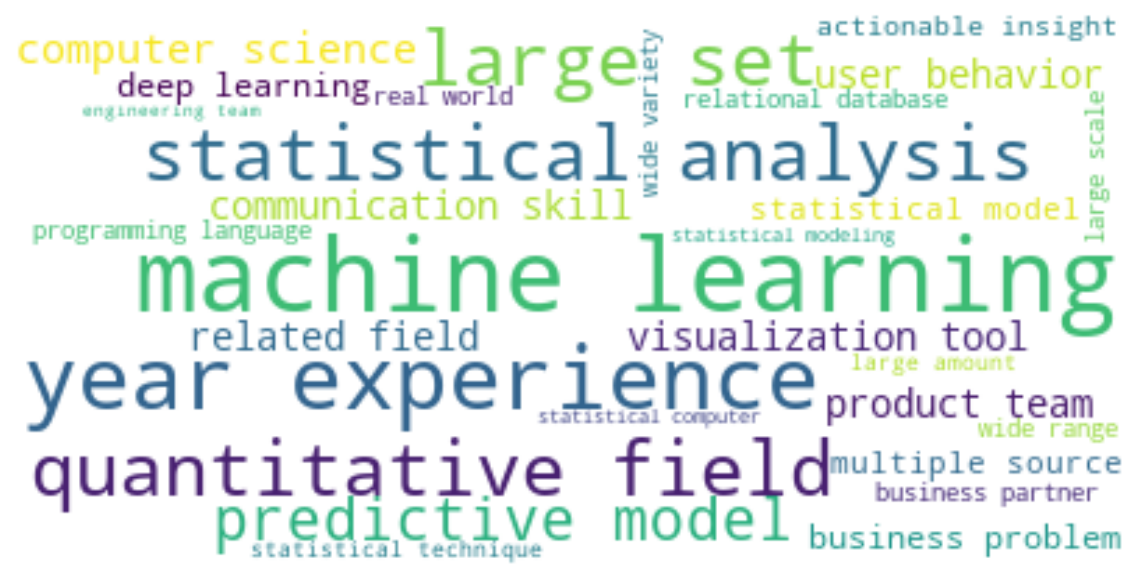

In [16]:
wc = WordCloud(background_color='white', collocations=False)
wc.generate_from_frequencies(dict(sum_dict))
plt.figure(figsize=(20,20))
plt.xticks([])
plt.yticks([])
plt.imshow(wc,interpolation="bilinear")
wc.to_file("phrases.png")

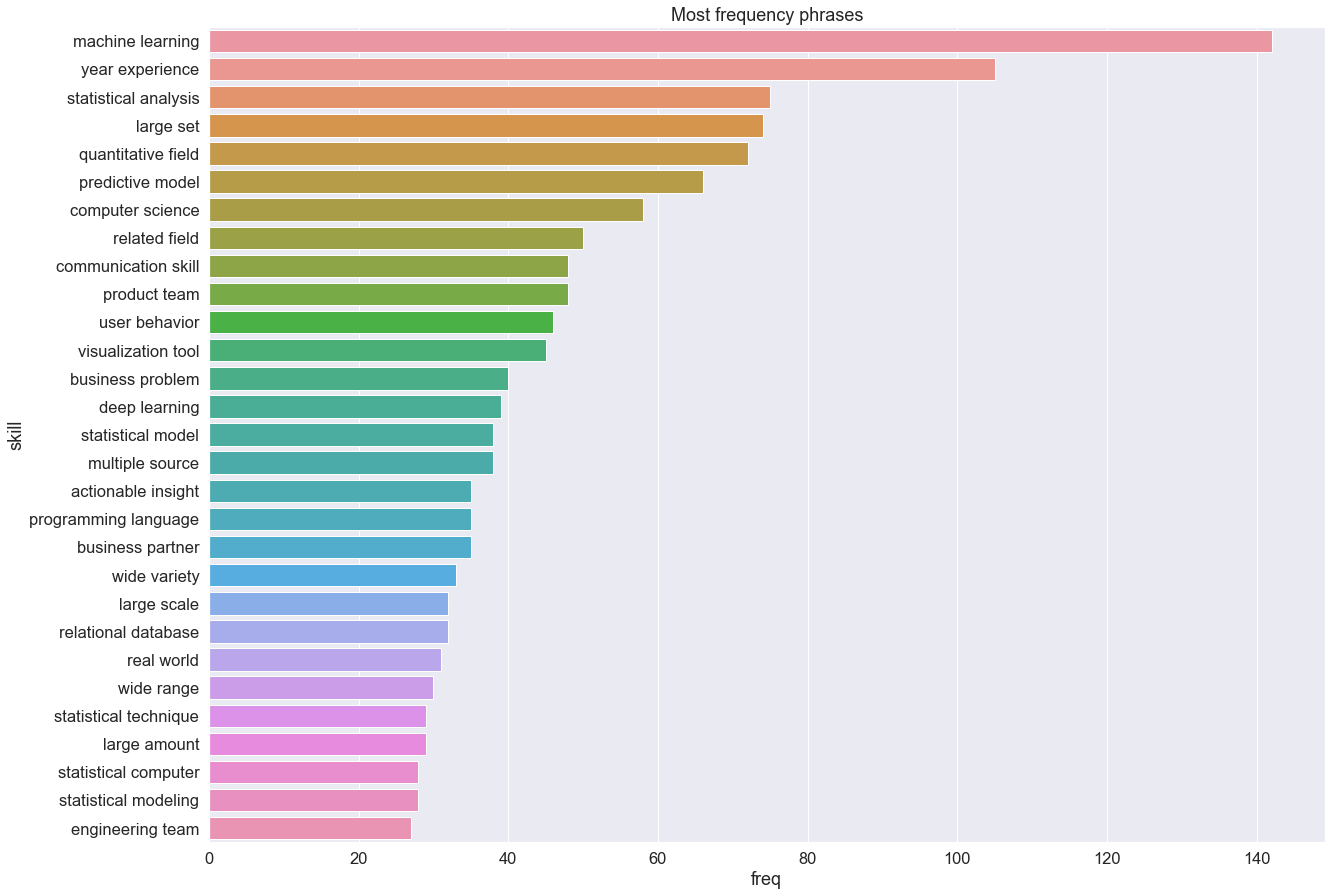

In [17]:
plt.figure(figsize=(20,15))
plt.title('Most frequency phrases')
g = sns.barplot(x='freq', y='skill', data=skill_df)

**it much obvious to get the phrases like "machine learning" and "statistical analysis" in our observation and so as "product team" and "cross-functional team" are not. There are more about soft skills that required for hiring. 
Everywhere we could read about for data science have to be able to share their insights through storytelling and in our research we could note a frequency of "communication skill" and the other side more frequency appeared "experience". I think these definitions about the same. Definitely, you can't be telling some great insights without being deep into a subject.
I try to get much objective result to get frequencies for core word: "communication skill", "experience", "quantitative", "team", "statistical", "visualization", "insight".


In [18]:
phrases_set = [{"communication skill"}, {"year experience"}, {"quantitative field"}, {"product team"}, {"statistical analysis"}, {"visualization"}, 
           {"actionable insight"}]

phrases = ["communication", "experience", "quantitative", "team", "statistical", "visualization","insight"]

count = [48, 105, 72, 48, 75, 45, 35]

In [19]:
for i in df_all_skills.index:
    val = df_all_skills.iat[i,0]
    l = val.split(' ')
    for word in l:
        if word in phrases:
            ind = phrases.index(word)
            _set = phrases_set[ind]
            _set.add(val)
            phrases_set[ind] = _set
            count[ind] = count[ind] + df_all_skills.iat[i,1]

**I looked at phrases with appearing in the different meaning

In [22]:
print(phrases_set[0])

{'strong communication', 'sqlstrong communication', 'clear communication', 'great communication', 'communication skillsexperience', 'cloudjavastrong communication', 'oral communication', 'communication coaching', 'proven communication', 'communication project', 'sasexcellent communication', 'plus communication', 'visual communication', 'open communication', 'assignment communication', 'environmentexcellent communication', 'mannersuperb communication', 'communication skillsma', 'communication technique', 'practicesstrong communication', 'communication style', 'javastrong communication', 'productionexcellent communication', 'communication platformspartner', 'effective communication', 'guidancestrong communication', 'efficient communication', 'structuresexcellent communication', 'regular communication', 'ownership communication', 'communication skill', 'extraordinary communication', 'verbal communication', 'communication skillsproficiency', 'excellent communication', 'communication verbal

In [23]:
print(phrases_set[1])

{'powerpoint experience', 'similar experience', 'yr experience', 'practical experience', 'consumer experience', 'markup experience', 'developer experience', 'result experience', 'past experience', 'manor experience', 'experiencebig experience', 'automotive experience', 'optimal experience', 'accessprior experience', 'player experience', 'internship experience', 'pluscareer experience', 'direct experience', 'previous experience', 'keras experience', 'issue experience', 'prior experience', 'experience python', 'plusprevious experience', 'awesome experience', 'displayed experience', 'relationshipsknowledge experience', 'plusproven experience', 'radvanced experience', 'algorithm experience', 'extensive experience', 'academic experience', 'question experience', 'analysis experience', 'analytics experience', 'practicespython experience', 'experience phd', 'experience may', 'relevant experience', 'experiment experience', 'technical experience', 'powerbi experience', 'industry experience', 're

In [24]:
print(phrases_set[2])

{'quantitative analysisbachelor', 'quantitative field', 'quantitative focus', 'requiredexcellent quantitative', 'quantitative skill', 'quantitative modeling', 'quantitative informationhelp', 'quantitative fieldexperience', 'quantitative position', 'quantitative disciplineexpertise', 'quantitative analysesmanipulates', 'quantitative fieldfluent', 'quantitative fieldcomfort', 'quantitative approachesexperience', 'quantitative area', 'verbal quantitative', 'quantitative analysesworks', 'quantitative topic', 'quantitative research', 'quantitative fieldhistory', 'quantitative framework', 'quantitative disciplinefamiliarity', 'quantitative solution', 'quantitative method', 'quantitative insight', 'quantitative input', 'day quantitative', 'quantitative subject', 'quantitative fieldknowledge', 'quantitative disciplineexperience', 'quantitative finance', 'quantitative evidence', 'quantitative disciplinesfamiliarity', 'quantitative fieldbackground', 'quantitative discipline', 'quantitative role'

In [25]:
print(phrases_set[3])

{'paradigm team', 'execution team', 'team membersbachelor', 'team individual', 'corporate team', 'team regardless', 'executive team', 'audience team', 'warehouse team', 'bi team', 'team settingms', 'team coach', 'customer team', 'production team', 'team playerbachelor', 'development team', 'team membersguide', 'diverse team', 'requiredexcellent team', 'several team', 'partner team', 'multiple team', 'strong team', 'analyticsthese team', 'team memberswork', 'entire team', 'team playerpassionate', 'growth team', 'entrepreneurial team', 'architecture team', 'global team', 'team walk', 'local team', 'flow team', 'infrastructure team', 'team diversity', 'visa team', 'software team', 'project team', 'team player', 'team settingtravel', 'distributed team', 'focused team', 'client team', 'team structure', 'amazon team', 'team extract', 'contractor team', 'qa team', 'engineering team', 'datarobot team', 'marketing team', 'design team', 'management team', 'team people', 'team orientation', 'team

In [26]:
print(phrases_set[4])

{'statistical application', 'statistical experience', 'statistical analytics', 'statistical solution', 'statistical package', 'statistical measure', 'statistical model', 'statistical principle', 'learned statistical', 'statistical language', 'statistical concept', 'statistical aggregationsdeveloping', 'statistical analysesdevelop', 'rigorous statistical', 'statistical theory', 'statistical methodology', 'statistical project', 'statistical methodsability', 'statistical significance', 'statistical platform', 'statistical software', 'statistical modelingexpertise', 'statistical knowledge', 'statistical technique', 'statistical program', 'statistical analysisfamiliarity', 'statistical analysisexperience', 'statistical programming', 'statistical analysisbuild', 'statistical computer', 'statistical consultant', 'statistical analysisknowledge', 'statistical segmentation', 'statistical approach', 'statistical modelling', 'statistical modelsdeep', 'statistical consulting', 'statistical efficien

In [27]:
print(phrases_set[5])

{'interactive visualization', 'exploration visualization', 'visualization display', 'visualization experience', 'clear visualization', 'visualization ability', 'informative visualization', 'dashboard visualization', 'visualization tool', 'visualization toolsexcellent', 'common visualization', 'visualization product', 'problemcreate visualization', 'visualization software', 'visualization skillsproficiency', 'advanced visualization', 'visualization specification', 'visualization toolsmanagement', 'visualization toolsexperience', 'visualization tableau', 'visualization toolsdefine', 'visualization effort', 'meaningful visualization', 'available visualization', 'socializationadvanced visualization', 'rich visualization', 'appropriate visualization', 'graphsdata visualization', 'plusdata visualization', 'analysis visualization', 'visualization technique', 'analysisdata visualization', 'visualization skill', 'building visualization', 'visualization library', 'superior visualization', 'deliv

In [32]:
count
#[48, 105, 72, 48, 75, 45, 35]
#[174, 794, 276, 492, 483, 175, 181]

[174, 794, 276, 492, 483, 175, 181]

In [33]:
_df = pd.DataFrame(count, columns=['freq'], index=phrases)

In [34]:
_df.sort_values(by='freq', ascending=False)

,freq
experience,794
team,492
statistical,483
quantitative,276
insight,181
visualization,175
communication,174


### How we can notice "experience" set the first place on the table and "team" the second. This result is not accurate. Otherwise, we could wonder the market requires specialists with different kind of experiences: analytical, technique or some professional in particular area. 

### For more accurate analysis we have to deep in NLP analysis. But for our purpose in this project, these conclusions are enough.

### There is example of a disription of one job posions. I notice necessary words for accounting could occur more than once (Python). To refrain from repetition i wrote an appropriate code where i've got one value from each proposition.

['You will implement and validate predictive models, and create and maintain statistical models with a focus on big data.You’ll communicate with internal and external clients to understand business needs and provide analytical solutions.You will use statistical concepts such as regression, time series, mixed model, Bayesian methods, clustering, etc., to analyze data and provide insights.You’ll work in an Agile, collaborative environment, partnering with other scientists, engineers, and database administrators of all backgrounds and disciplines to bring analytical rigor and statistical methods to the challenges of predicting behaviors.You are great at solving problems, debugging, troubleshooting, and designing & implementing solutions to complex technical issues.You thrive on teamwork and have excellent verbal and written communication skills.You have strong technical and analytical abilities, a knack for driving impact and growth, and some experience with programming/scripting in a language such as Java or **Python**.You have a basic understanding of statistical programming in a language such as R, SAS, or **Python**.You have an interest in, understanding of, or experience with Design Thinking MethodologyYou have an interest in, understanding of, or experience with Agile development methodology']

In [40]:
dict_lang = {'r':0, 'sas':0, 'python':0, 'weka':0, 'numpy':0, 'matlab':0,'sql':0,'spss':0,'bi':0,'scikit':0,'aws':0,
             'nlp':0,'matlab':0,'scala':0,'java':0,'hadoop':0,'spark':0,'tableau':0, 'xgboost':0,'c':0,
             'cloud':0,'excel':0,'keras':0 ,'nosql':0, 'bash':0, 'php':0, 'perl':0, 'ruby':0, 'linux':0}
counter1 = Counter()
reviews = df2['text']
for comment in reviews:
    # set includes word only one time
    s = set()
    [s.add(word.lower()) for word in re.findall(r'\w+', comment) 
                        if (word.lower() not in stopwords) and (len(word) <= 7) and (word.lower() not in FilterWords) 
                        and (word.lower() in dict_lang)]
    counter1.update(s)
 

In [41]:
df = pd.DataFrame.from_dict(counter1, orient='index').reset_index()

In [42]:
df = df.rename(columns={"index": "tool", 0: "freq"})
df.reset_index()
df.sort_values(['freq'], inplace=True, ascending=False)
df

,tool,freq
2,python,643
3,r,544
12,sql,408
17,spark,214
13,hadoop,208
1,java,169
0,sas,162
4,c,138
20,tableau,115
15,matlab,100


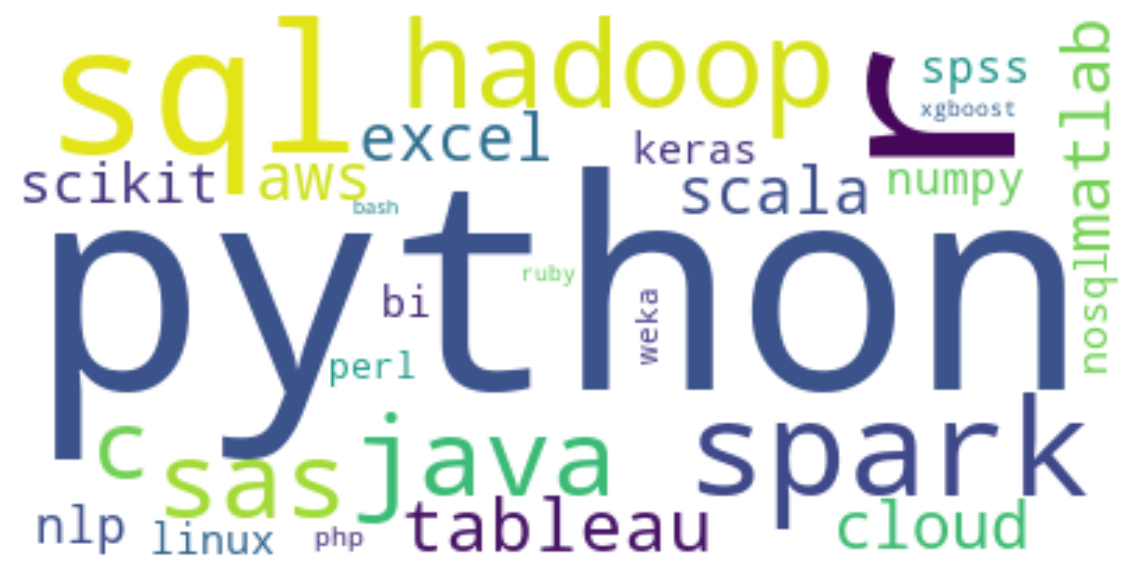

In [43]:
df_dict = dict(zip(df['tool'],df['freq']))
wc.generate_from_frequencies(dict(df_dict))
plt.figure(figsize=(20,20))
plt.xticks([])
plt.yticks([])
plt.imshow(wc,interpolation="bilinear")

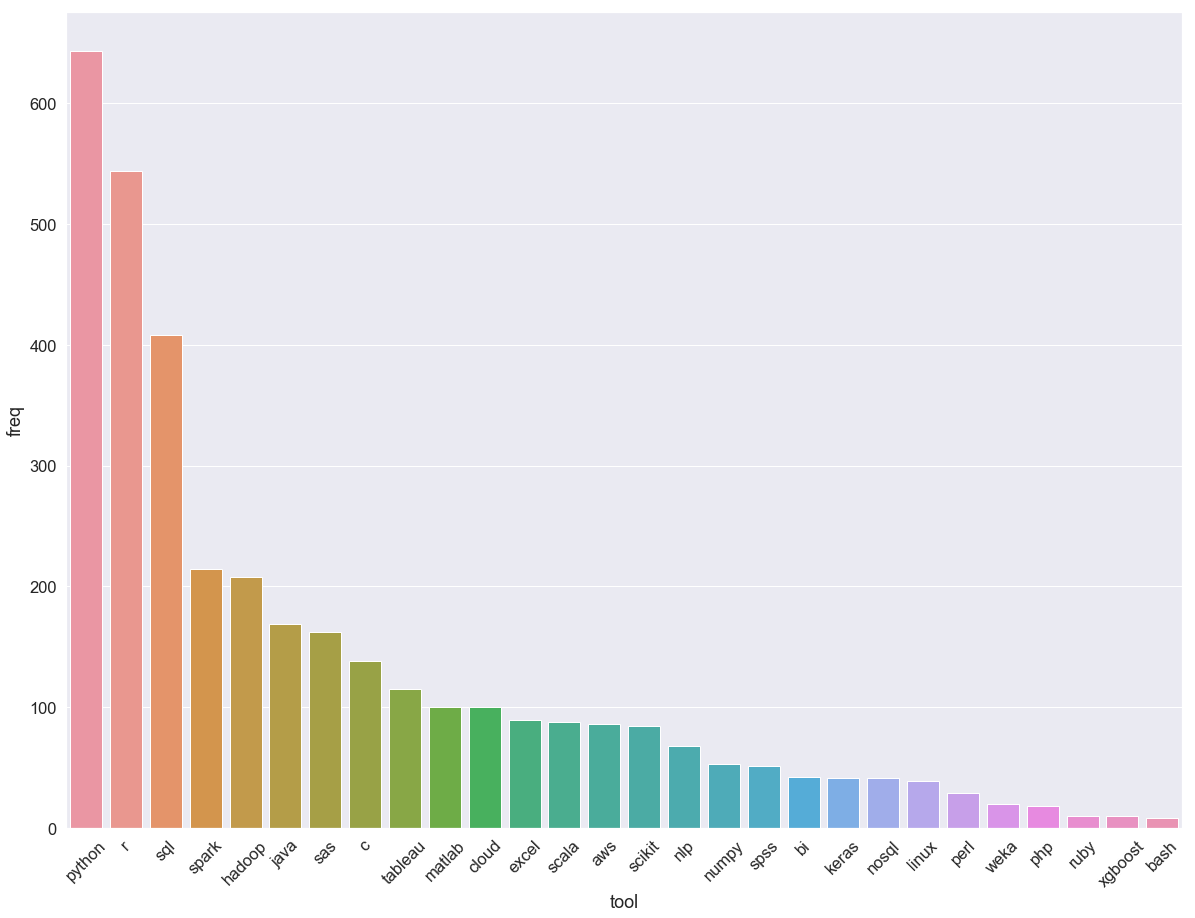

In [45]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='tool',y='freq',data=df)
_ = plt.setp(g.get_xticklabels(), rotation=45)

### We could mark most required tech tools

In [233]:
# to compare result with Kaggle's observation
df.to_csv('E:\\KSE\\DS\\Course Project\\Indeen_lang.csv')

### I collected compensation information from "Indeed". But the small account of companies declared this information. Only 251 from 1073.

In [46]:
salary_df = df2.dropna(axis=0,subset=['jobsalary'])
salary_df.reset_index(drop=True, inplace=True)

In [47]:
# getting mean salary from range 
def get_salary(text):
    coef = 1
    f = text.rfind('year')
    if f == -1:
        f = text.rfind('month')
        if f == -1:
            return 0 
        else:
            coef = 12
            
    f = text.rfind('$')
    _f = text.find('$')
    s = text.find(' ',f)
    salary = int(text[(f+1):s].replace(',',''))
    if f != _f:
        s = text.find(' ',_f)
        _salary = float(text[(_f+1):s].replace(',',''))
        salary = (salary + _salary)/2
     
    return  salary*coef  

salary_df['salary'] = salary_df[['jobsalary']].applymap(lambda x: get_salary(x))

In [48]:
#filtered year's and month's compensation
salary_df = salary_df[salary_df['salary'] != 0]
salary_df.reset_index(inplace=True)

In [49]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 11 columns):
index             251 non-null int64
Unnamed: 0        251 non-null int64
Unnamed: 0.1      251 non-null int64
Unnamed: 0.1.1    251 non-null int64
link              251 non-null object
jobtitle          251 non-null object
jobcompany        251 non-null object
joblocation       251 non-null object
jobsalary         251 non-null object
text              251 non-null object
salary            251 non-null float64
dtypes: float64(1), int64(4), object(6)
memory usage: 21.6+ KB


In [50]:
counter = Counter()
for x in range(len(salary_df)):
    review = salary_df['text'][x]
    counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))

In [58]:
df_salary_skills = pd.DataFrame.from_dict(counter, orient='index')
df_salary_skills = df_salary_skills.rename(columns={"index": "skill", 0: "freq"})
df_salary_skills.sort_values(['freq'], inplace=True, ascending=False)

In [62]:
df_salary_skills.reset_index(inplace=True)
df_salary_skills = df_salary_skills.rename(columns={"index": "skill"})
df_salary_skills

,level_0,skill,freq
0,0,machine learning,32
1,1,year experience,29
2,2,statistical analysis,26
3,3,predictive model,19
4,4,deep learning,19
5,5,wide variety,19
6,6,quantitative field,16
7,7,communication skill,16
8,8,statistical method,12
9,9,visualization tool,12


In [63]:
df_salary_skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935 entries, 0 to 2934
Data columns (total 3 columns):
level_0    2935 non-null int64
skill      2935 non-null object
freq       2935 non-null int64
dtypes: int64(2), object(1)
memory usage: 68.9+ KB


In [64]:
topk_salary = df_salary_skills[['skill','freq']].values.tolist()

In [65]:
topk_salary[:30]

[['machine learning', 32],
 ['year experience', 29],
 ['statistical analysis', 26],
 ['predictive model', 19],
 ['deep learning', 19],
 ['wide variety', 19],
 ['quantitative field', 16],
 ['communication skill', 16],
 ['statistical method', 12],
 ['visualization tool', 12],
 ['software engineer', 12],
 ['related field', 11],
 ['wide range', 11],
 ['software development', 11],
 ['large amount', 11],
 ['model development', 11],
 ['statistical model', 10],
 ['business problem', 10],
 ['large set', 9],
 ['large datasets', 9],
 ['service ability', 9],
 ['predictive modeling', 9],
 ['relational database', 8],
 ['quantitative analysis', 8],
 ['product team', 8],
 ['solution support', 8],
 ['competitor insight', 8],
 ['analysis software', 8],
 ['summarization query', 8],
 ['multiple source', 7]]

In [66]:
#Find out if a particular review has the word from topk list
freq = []
for i in range(len(salary_df)):
    review = salary_df['text'][i]
    temp = Counter(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',review))))]))
    inReview = []
    for (word,wordCount) in topk_salary:
        if word in temp:
            inReview.append(1)
        else:
            inReview.append(0)
    freq.append(inReview)
        
#Prepare freqReviewDf
freqDf = pd.DataFrame(freq)
dfName = []
for c in topk_salary:
    dfName.append(c[0])
freqDf.columns = dfName

In [67]:
sum_df = salary_df.merge(freqDf, left_index=True, right_index=True)

In [68]:
def my_sum(row):
    return row[dfName].sum()

sum_df['skills'] = sum_df[dfName].apply(my_sum, axis=1)

In [69]:
group_salary = sum_df.groupby('salary')[dfName].sum()

In [70]:
group_salary.reset_index(inplace=True)

In [71]:
group_salary.describe()

,salary,machine learning,year experience,statistical analysis,predictive model,deep learning,wide variety,quantitative field,communication skill,statistical method,...,big strategywork,good judgement,community level,market parameter,optimal experience,production product,similar web,kind leader,team people,various type
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,112399.250000,0.537037,0.314815,0.351852,0.351852,0.240741,0.277778,0.296296,0.259259,0.148148,...,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519
std,56067.912773,1.111059,0.796788,0.872156,0.914401,0.725159,0.596109,0.633339,0.555765,0.358583,...,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083
min,32500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75267.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,110500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,131250.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,350000.000000,5.000000,3.000000,5.000000,6.000000,4.000000,3.000000,3.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
group_salary['groups']=pd.cut(group_salary.salary,[32499,70000,100000,350001])

In [73]:
group_salary['groups']

0       (32499, 70000]
1       (32499, 70000]
2       (32499, 70000]
3       (32499, 70000]
4       (32499, 70000]
5       (32499, 70000]
6       (32499, 70000]
7       (32499, 70000]
8       (32499, 70000]
9       (32499, 70000]
10      (32499, 70000]
11      (32499, 70000]
12     (70000, 100000]
13     (70000, 100000]
14     (70000, 100000]
15     (70000, 100000]
16     (70000, 100000]
17     (70000, 100000]
18     (70000, 100000]
19     (70000, 100000]
20     (70000, 100000]
21     (70000, 100000]
22     (70000, 100000]
23    (100000, 350001]
24    (100000, 350001]
25    (100000, 350001]
26    (100000, 350001]
27    (100000, 350001]
28    (100000, 350001]
29    (100000, 350001]
30    (100000, 350001]
31    (100000, 350001]
32    (100000, 350001]
33    (100000, 350001]
34    (100000, 350001]
35    (100000, 350001]
36    (100000, 350001]
37    (100000, 350001]
38    (100000, 350001]
39    (100000, 350001]
40    (100000, 350001]
41    (100000, 350001]
42    (100000, 350001]
43    (1000

In [74]:
group_salary['groups'].value_counts()

(100000, 350001]    31
(32499, 70000]      12
(70000, 100000]     11
Name: groups, dtype: int64

In [75]:
_group_salary = group_salary.groupby('groups')[dfName].sum()

In [76]:
_group_salary

,machine learning,year experience,statistical analysis,predictive model,deep learning,wide variety,quantitative field,communication skill,statistical method,visualization tool,...,big strategywork,good judgement,community level,market parameter,optimal experience,production product,similar web,kind leader,team people,various type
groups,,,,,,,,,,,,,,,,,,,,,
"(32499, 70000]",5,6,3,3,1,3,4,5,1,3,...,0,0,1,1,1,1,1,1,1,0
"(70000, 100000]",5,7,4,2,4,6,5,3,1,4,...,0,0,0,0,0,0,0,0,0,0
"(100000, 350001]",19,4,12,14,8,6,7,6,6,5,...,1,1,0,0,0,0,0,0,0,1


In [77]:
_group_salary.reset_index(inplace=True)

In [78]:
skills_most_salary = _group_salary.iloc[2][dfName].values

In [79]:
skills = skills_most_salary.tolist()

In [80]:
skills_array = list(zip(dfName,skills))

In [81]:
df_salary_skills = pd.DataFrame(skills_array, columns=['skill','freq'])

In [82]:
df_salary_skills = df_salary_skills.drop(df_salary_skills[(df_salary_skills.freq == 0)].index)

In [83]:
df_salary_skills.sort_values(['freq'], inplace=True, ascending=False)

I prepared distribution in case the compensation of more than $100th a year and collected skills from the data.

In [84]:
df_salary_skills[0:30]

,skill,freq
0,machine learning,19
3,predictive model,14
2,statistical analysis,12
4,deep learning,8
6,quantitative field,7
19,large datasets,7
14,large amount,7
5,wide variety,6
7,communication skill,6
8,statistical method,6


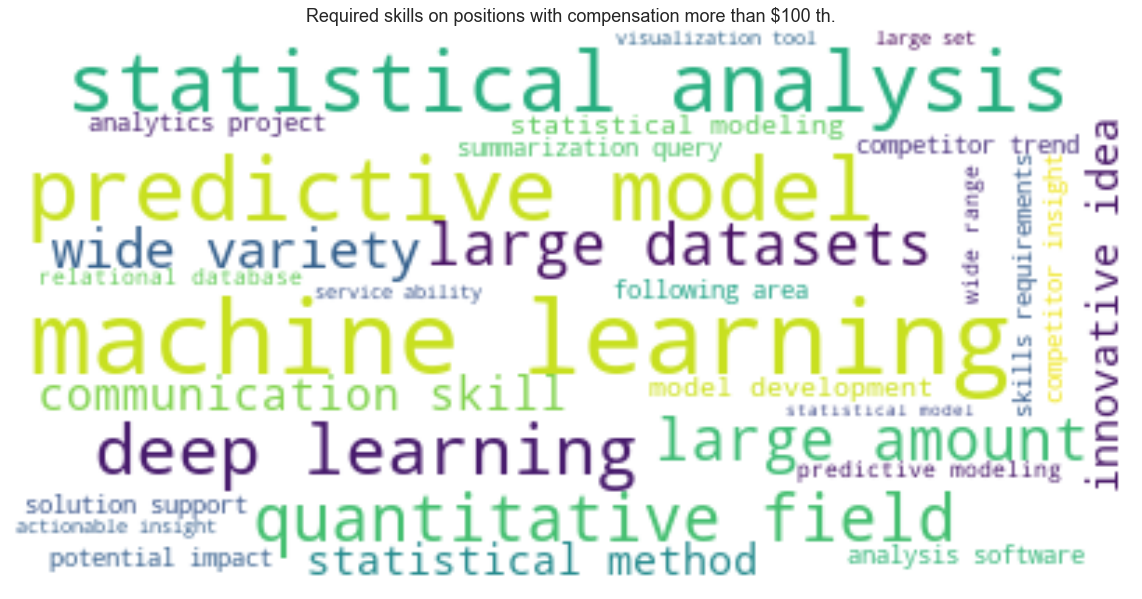

In [85]:
_df = df_salary_skills[0:30]
df_dict = dict(zip(_df['skill'],_df['freq']))
wc.generate_from_frequencies(dict(df_dict))
plt.figure(figsize=(20,20))
plt.title('Required skills on positions with compensation more than $100 th.')
plt.xticks([])
plt.yticks([])
plt.imshow(wc,interpolation="bilinear")

the probability distribution is a description of a random phenomenon in terms of the probabilities of events.
We can't say our captured data are random. And there is the sample with 251 positions and do some prediction no sense.

# In this case, we can see that tech skills took up top positions: 'machine learning', 'predictive model', 'statistical analysis', 'deep learning', 'quantitative field', 'large datasets' and then 'communication skill' and 'innovative idea'.